Some of the code was inspired or cloned from these githubs👏

https://github.com/adventuresinML/adventures-in-ml-code/blob/master/dueling_q_tensorflow2.py </br>
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/   </br>
https://github.com/rharish101/PongRL</br>

In [1]:
import gym
import tensorflow as tf
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from memory import replay_buffer, frame_stack
from models import agent, encoder, decoder, combine

In [2]:
eps = 1
eps_min = 0.1
decay_episodes = 100

DELAY_TRAINING = 100
DISCOUNT_FACTOR = 0.99
BATCH_SIZE = 32
TAU = 0.08

env = gym.make("Pong-v0")

In [3]:
class DQNAgent:
    def __init__(self, env, gamma, tau, batch_size):
        
        #Environment
        self.state_size = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        
        #Initiate networks
        self.qnet = agent(32, 32, self.num_actions)
        self.qnet_target = agent(32, 32, self.num_actions)
        
        self.enc_target = encoder((160,160,3),32,5)
        self.enc = encoder((160,160,3),32,5)
    
        self.dec = decoder((160,160,3),32,5)
        
        #Create combined networks
        self.primary_network = Model(inputs=self.enc.input, outputs=self.qnet(self.enc.output))
        self.target_network = Model(inputs=self.enc_target.input, outputs=self.qnet_target(self.enc_target.output))
        self.autoencoder = Model(inputs=self.enc.input, outputs=self.dec(self.enc.output))
        
        #Declare optimizers
        self.ae_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.q_optimizer = tf.keras.optimizers.Adam(2.5e-4)
        
        #sets the initial weights and baises to be equal
        for t, e in zip(self.target_network.trainable_variables, self.primary_network.trainable_variables):
            t.assign(e)
        
        #Initiate memory
        self.qtable = replay_buffer(500000)
        self.frame_stack = frame_stack(4, (160,160))
        
        #Storing hyperparameters
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
    
    def choose_action(self, frames, eps):
        if random.random() < eps:
            return env.action_space.sample()
        else:
            return np.argmax(self.primary_network.predict(np.expand_dims(frames[:,:,1:4], axis=0))[0])
        
    def preprocess_frame(self,frame):
        resized = frame[32:192,0:160,:]
        gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)/255.
        return gray.astype(np.float32)
    
    def update_network(self):
        for t, e in zip(self.target_network.trainable_variables, self.primary_network.trainable_variables):
            t.assign(t * (1 - self.tau) + e * self.tau)
        
    @tf.function
    def train(self):
        batch = self.qtable.sample(BATCH_SIZE)
        all_states = np.array([val[0] for val in batch], dtype=np.float32)
        actions = np.array([val[1] for val in batch])
        rewards = np.array([val[2] for val in batch], dtype=np.float32)
        terminals = np.array([val[3] for val in batch])
        states = all_states[:,:,:,0:3]
        next_states = all_states[:,:,:,1:4]

        with tf.GradientTape() as q_tape, tf.GradientTape() as ae_tape:
            
            prim_qt = DQNAgent.primary_network(states, training=True)
            prim_qtp1 = DQNAgent.primary_network(next_states, training=True)
            q_from_target = DQNAgent.target_network(next_states, training=True)

            mask = tf.cast(tf.logical_not(terminals), tf.float32)

            batch_range = tf.range(self.batch_size, dtype=tf.int64)

            tgt_indices = tf.stack([batch_range, tf.argmax(prim_qtp1, axis=1)], axis=1)
            q_final = tf.gather_nd(q_from_target , tgt_indices)
            targets = rewards + mask * self.gamma * q_final

            pred_indices = tf.stack([batch_range, actions], axis=1)
            pred = tf.gather_nd(prim_qt, pred_indices)
            q_loss = tf.keras.losses.Huber()(targets, pred)

            #generated_states = DQNAgent.autoencoder(states)
            #ae_loss = tf.keras.losses.binary_crossentropy(states, generated_states)
          
        #ae_gradients = ae_tape.gradient(ae_loss, self.autoencoder.trainable_variables)
        q_gradients = q_tape.gradient(q_loss, self.primary_network.trainable_variables)   
        
        #self.ae_optimizer.apply_gradients(zip(ae_gradients, self.autoencoder.trainable_variables))
        self.q_optimizer.apply_gradients(zip(q_gradients, self.primary_network.trainable_variables))
        self.update_network()
        
        return q_loss
    
DQNAgent = DQNAgent(env, gamma = DISCOUNT_FACTOR, tau = TAU, batch_size = BATCH_SIZE)

In [4]:
num_episodes = 1000
rewards = []
avg_rewards = []
loss = []
eps_decay = np.power(eps_min, 1/decay_episodes)

for episode in range(num_episodes):
    episode_reward = 0
    steps = 0
    q_loss = 0
    state = env.reset()
    frames = DQNAgent.frame_stack.query(DQNAgent.preprocess_frame(state), True)
    while True:
        env.render()
        action = DQNAgent.choose_action(frames, eps)
        
        state, reward, done, info = env.step(action)
        frames = DQNAgent.frame_stack.query(DQNAgent.preprocess_frame(state), False)
        experience = frames, action, reward, done
        DQNAgent.qtable.store(experience)

        episode_reward += reward
        steps += 1

        if episode > DELAY_TRAINING:
            q_loss += DQNAgent.train()
            
        if done:
            if episode > DELAY_TRAINING:
                print("episode: {}, eps: {}, reward: {}, average reward: {}, q loss: {}".format(episode, np.round(eps, decimals=2), np.round(episode_reward, decimals=2), np.mean(rewards[-10:]), np.round(q_loss/steps, decimals=2)))
                
                if eps > eps_min:
                    eps *= eps_decay
                
                rewards.append(episode_reward)
                avg_rewards.append(np.mean(rewards[-10:]))
            else:
                print("episode: {}, eps: {}, pretraining...".format(episode, np.round(eps, decimals=2), decimals=2))
            break
            
env.close()
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()        

episode: 0, eps: 1, pretraining...
episode: 1, eps: 1, pretraining...
episode: 2, eps: 1, pretraining...
episode: 3, eps: 1, pretraining...
episode: 4, eps: 1, pretraining...
episode: 5, eps: 1, pretraining...
episode: 6, eps: 1, pretraining...
episode: 7, eps: 1, pretraining...
episode: 8, eps: 1, pretraining...
episode: 9, eps: 1, pretraining...
episode: 10, eps: 1, pretraining...
episode: 11, eps: 1, pretraining...
episode: 12, eps: 1, pretraining...
episode: 13, eps: 1, pretraining...
episode: 14, eps: 1, pretraining...
episode: 15, eps: 1, pretraining...
episode: 16, eps: 1, pretraining...
episode: 17, eps: 1, pretraining...
episode: 18, eps: 1, pretraining...
episode: 19, eps: 1, pretraining...
episode: 20, eps: 1, pretraining...
episode: 21, eps: 1, pretraining...
episode: 22, eps: 1, pretraining...
episode: 23, eps: 1, pretraining...
episode: 24, eps: 1, pretraining...
episode: 25, eps: 1, pretraining...
episode: 26, eps: 1, pretraining...
episode: 27, eps: 1, pretraining...
ep

C:\Users\kipst\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kipst\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 101, eps: 1, reward: -21.0, average reward: nan, q loss: 0.09000000357627869
episode: 102, eps: 0.98, reward: -20.0, average reward: -21.0, q loss: 253.82000732421875
episode: 103, eps: 0.95, reward: -21.0, average reward: -20.5, q loss: 64640260.0
episode: 104, eps: 0.93, reward: -21.0, average reward: -20.666666666666668, q loss: 13262857216.0
episode: 105, eps: 0.91, reward: -20.0, average reward: -20.75, q loss: 908315721728.0
episode: 106, eps: 0.89, reward: -20.0, average reward: -20.6, q loss: 295078480314368.0
episode: 107, eps: 0.87, reward: -20.0, average reward: -20.5, q loss: 3.017900861213901e+16
episode: 108, eps: 0.85, reward: -21.0, average reward: -20.428571428571427, q loss: 5.5365880528869786e+17
episode: 109, eps: 0.83, reward: -20.0, average reward: -20.5, q loss: 1.559443801305514e+18
episode: 110, eps: 0.81, reward: -20.0, average reward: -20.444444444444443, q loss: 2.7688413770756915e+17
episode: 111, eps: 0.79, reward: -21.0, average reward: -20.4, q 

GLException: b'out of memory'

In [ ]:
env.close()

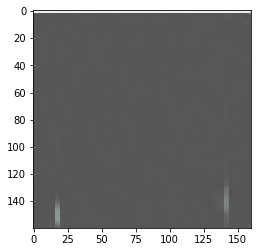

In [5]:
plt.imshow(DQNAgent.autoencoder.predict(np.expand_dims(frames[:,:,1:4], axis=0))[0])

In [16]:
batch = DQNAgent.qtable.sample(BATCH_SIZE)
all_states = np.array([val[0] for val in batch], dtype=np.float32)
actions = np.array([val[1] for val in batch])
rewards = np.array([val[2] for val in batch], dtype=np.float32)
states = all_states[:,:,:,0:3]
next_states = all_states[:,:,:,1:4]

In [23]:
frames[:,:,1:4].shape

(160, 160, 3)

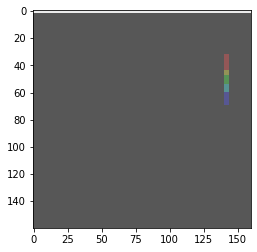

In [15]:
plt.imshow(frames[:,:,1:4])